In [2]:
# Import statements
import os
import traceback
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from LearningSession import *
from LearningChoicePredictor import *

In [3]:
animal = 'mSM63'
folder = '/home/chingf/engram/data/musall/learning/neural/mSM63'
dates = os.listdir(folder)
dates.sort()
dates = dates[1:]
dates.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y')) 

## Looking at performance

/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Learning Data Mouse mSM63')

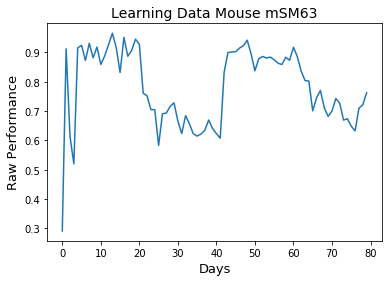

In [8]:
# Collects accuracy values
raw_accuracy = []
aud_accuracy = []
tac_accuracy = []
p_aud = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_neural=False
        )
    is_aud_trial = np.array(session.is_aud_trial).astype(bool)
    aud_indices = np.argwhere(is_aud_trial)
    tac_indices = np.argwhere(np.logical_not(is_aud_trial))
    p_aud.append(
        np.sum(session.is_aud_trial)/len(session.is_aud_trial)
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    raw_accuracy.append(
        np.sum(expected == actual)/(1.0*expected.size)
        )
    aud_expected = expected[aud_indices]
    aud_actual = actual[aud_indices]
    tac_expected = expected[tac_indices]
    tac_actual = actual[tac_indices]
    aud_accuracy.append(
        np.sum(aud_expected == aud_actual)/(1.0*aud_expected.size)
        )
    tac_accuracy.append(
        np.sum(tac_expected == tac_actual)/(1.0*tac_expected.size)
        )
    
plt.plot(raw_accuracy)
plt.ylabel("Raw Performance", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)

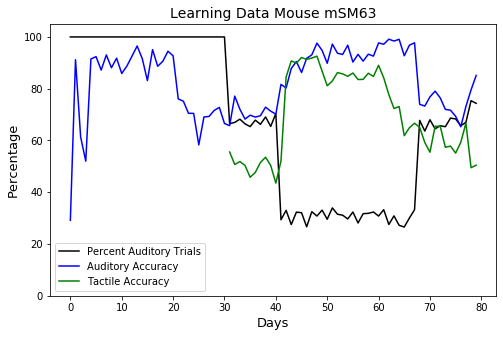

In [16]:
# Plots auditory-only accuracy
p_aud = np.array(p_aud)
aud_accuracy = np.array(aud_accuracy)
tac_accuracy = np.array(tac_accuracy)
plt.figure(figsize=(8,5))
plt.plot(p_aud*100, color="black", label="Percent Auditory Trials")
plt.plot(aud_accuracy*100, color="blue", label="Auditory Accuracy")
plt.plot(tac_accuracy*100, color="green", label="Tactile Accuracy")
plt.ylabel("Percentage", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.ylim((0,105))
plt.legend()
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.show()

## Dataset details
(The following information is 0-indexed).

The trials are auditory only from days 0-30. From days 31-40, the trials are 70/30 auditory/tactile. From days 41-67, the trials are 30/70 auditory/tactile.

The trials include discrimination starting on day 21

Text(0.5, 1.0, 'Learning Data Mouse mSM63')

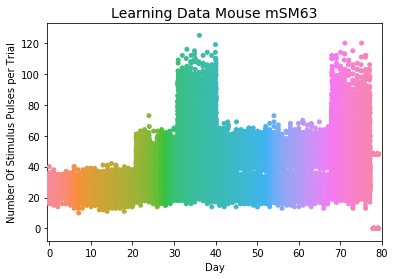

In [21]:
# Collects accuracy values
import pandas as pd
import seaborn as sns
num_stims = []
days = []
for date_idx, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_neural=False
        )
    num_trials = session.trialmarkers['CorrectSide'].size
    for i in range(num_trials):
        ns = session.trialmarkers['tacStimL'][i].size + \
            session.trialmarkers['tacStimR'][i].size + \
            session.trialmarkers['audStimL'][i].size + \
            session.trialmarkers['audStimR'][i].size
        num_stims.append(ns)
        days.append(date_idx)
df = pd.DataFrame({
    'Number Of Stimulus Pulses per Trial': num_stims,
    'Day': days
    })
sns.stripplot(
    x='Day', y='Number Of Stimulus Pulses per Trial',
    data=df
    )
plt.xticks(np.arange(0,90,10),np.arange(0,90,10))
plt.title("Learning Data Mouse mSM63", fontsize=14)

## Looking at simple info

What is the proportion of auditory left/right as defined by experiment?

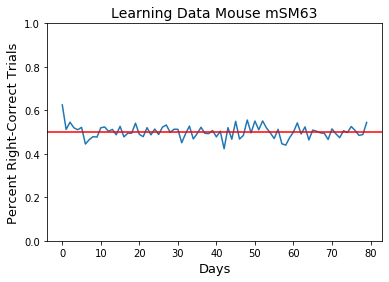

In [16]:
# Plots percent right
p_right = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    is_aud_trial = np.array(session.is_aud_trial)
    indices = np.argwhere(is_aud_trial)
    expected = np.array(
        session.trialmarkers['CorrectSide'][indices]
        )
    p_right.append(np.sum(expected == 2)*1.0/expected.size)
fig, ax = plt.subplots()
plt.plot(p_right)
plt.ylabel("Percent Right-Correct Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.ylim((0,1.0))
ax.axhline(0.5, color='red')
plt.show()

What is the proportion of left/right that the mouse chooses in auditory trials?

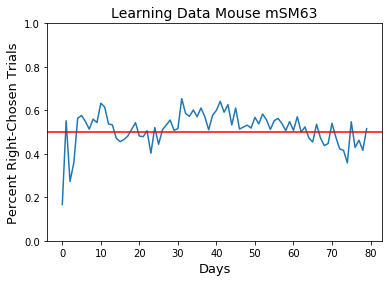

In [17]:
# Plots percent right
p_right_chosen = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    is_aud_trial = np.array(session.is_aud_trial)
    indices = np.argwhere(is_aud_trial)
    expected = np.array(
        session.trialmarkers['ResponseSide'][indices]
        )
    p_right_chosen.append(
        np.sum(expected == 2)*1.0/expected.size
        )
fig, ax = plt.subplots()
ax.plot(p_right_chosen)
plt.ylabel("Percent Right-Chosen Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.ylim((0.0,1.0))
ax.axhline(0.5, color="red")
plt.show()

Looking at choice transitions from previous trial to current trial

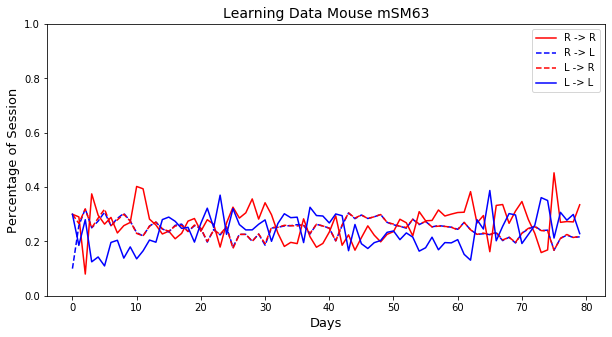

In [28]:
# Plots percent right
right_to_right = []
right_to_left = []
left_to_left = []
left_to_right = []
date_nums = []
for date_num, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    actual = np.array(session.trialmarkers['ResponseSide'])
    counter = 0
    r_to_r = 0
    r_to_l = 0
    l_to_l = 0
    l_to_r = 0
    for idx in np.arange(1, actual.size):
        if actual[idx - 1] == 1: # Left
            if actual[idx] == 1: # To Left
                l_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                l_to_r += 1
                counter += 1
        elif actual[idx - 1] == 2: # Right
            if actual[idx] == 1: # To Left
                r_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                r_to_r += 1
                counter += 1
    right_to_right.append(r_to_r/(counter*1.0))
    right_to_left.append(r_to_l/(counter*1.0))
    left_to_left.append(l_to_l/(counter*1.0))
    left_to_right.append(l_to_r/(counter*1.0))
    date_nums.append(date_num)
plt.figure(figsize=(10,5))
plt.plot(date_nums, right_to_right, "r-", label="R -> R")
plt.plot(date_nums, right_to_left, "b--", label="R -> L")
plt.plot(date_nums, left_to_right, "r--", label="L -> R")
plt.plot(date_nums, left_to_left, "b-", label="L -> L")
plt.ylabel("Percentage of Session", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.legend()
plt.ylim((0,1))
plt.show()

Looking at choice transitions from previous trial to current trial, for only incorrect trials

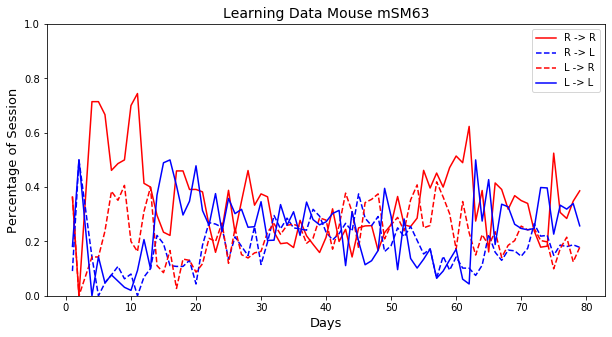

In [29]:
# Plot
right_to_right = []
right_to_left = []
left_to_left = []
left_to_right = []
date_nums = []
for date_num, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    incorrect_trials = np.argwhere(expected != actual)
    counter = 0
    r_to_r = 0
    r_to_l = 0
    l_to_l = 0
    l_to_r = 0
    for idx in incorrect_trials:
        if actual[idx - 1] == 1: # Left
            if actual[idx] == 1: # To Left
                l_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                l_to_r += 1
                counter += 1
        elif actual[idx - 1] == 2: # Right
            if actual[idx] == 1: # To Left
                r_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                r_to_r += 1
                counter += 1
    if counter > 0:
        right_to_right.append(r_to_r/(counter*1.0))
        right_to_left.append(r_to_l/(counter*1.0))
        left_to_left.append(l_to_l/(counter*1.0))
        left_to_right.append(l_to_r/(counter*1.0))
        date_nums.append(date_num)
plt.figure(figsize=(10,5))
plt.plot(date_nums, right_to_right, "r-", label="R -> R")
plt.plot(date_nums, right_to_left, "b--", label="R -> L")
plt.plot(date_nums, left_to_right, "r--", label="L -> R")
plt.plot(date_nums, left_to_left, "b-", label="L -> L")
plt.ylabel("Percentage of Session", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.legend()
plt.ylim((0,1))
plt.show()

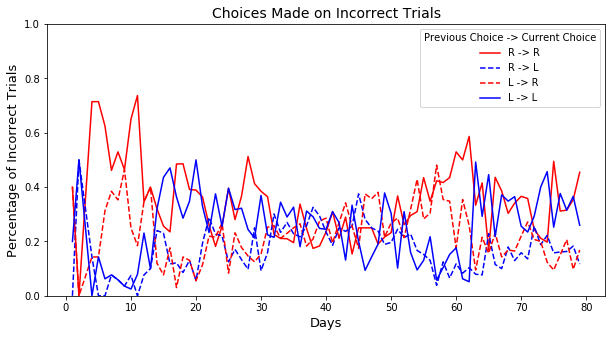

In [6]:
# Plot
right_to_right = []
right_to_left = []
left_to_left = []
left_to_right = []
date_nums = []
counters = []
for date_num, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    incorrect_trials = np.argwhere(expected != actual)
    counter = 0
    r_to_r = 0
    r_to_l = 0
    l_to_l = 0
    l_to_r = 0
    total_rs = 0
    total_ls = 0
    for idx in incorrect_trials:
        if expected[idx - 1] != actual[idx - 1]:
            continue
        if actual[idx - 1] == 1: # Left
            if actual[idx] == 1: # To Left
                l_to_l += 1
                total_ls += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                l_to_r += 1
                total_rs += 1
                counter += 1
        elif actual[idx - 1] == 2: # Right
            if actual[idx] == 1: # To Left
                r_to_l += 1
                total_ls += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                r_to_r += 1
                total_rs += 1
                counter += 1
    counters.append(counter)
    if counter > 0:
        right_to_right.append(r_to_r/(counter*1.0))
        right_to_left.append(r_to_l/(counter*1.0))
        left_to_left.append(l_to_l/(counter*1.0))
        left_to_right.append(l_to_r/(counter*1.0))
        date_nums.append(date_num)
plt.figure(figsize=(10,5))
plt.plot(date_nums, right_to_right, "r-", label="R -> R")
plt.plot(date_nums, right_to_left, "b--", label="R -> L")
plt.plot(date_nums, left_to_right, "r--", label="L -> R")
plt.plot(date_nums, left_to_left, "b-", label="L -> L")
plt.ylabel("Percentage of Incorrect Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Choices Made on Incorrect Trials", fontsize=14)
plt.legend(title="Previous Choice -> Current Choice")
plt.ylim((0,1))
plt.show()

Looking at choice for only incorrect trials

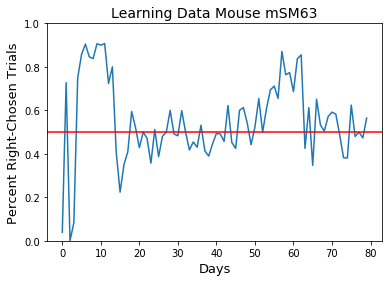

In [21]:
# Plots percent right
p_right_chosen = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    incorrect_trials = np.argwhere(expected != actual)
    incorrect_responses = actual[incorrect_trials]
    p_right_chosen.append(
        np.sum(incorrect_responses == 2)*1.0/incorrect_responses.size
        )
fig, ax = plt.subplots()
ax.plot(p_right_chosen)
plt.ylabel("Percent Right-Chosen Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.ylim((0.0,1.0))
ax.axhline(0.5, color="red")
plt.show()

## Looking at Choice Decoding

In [11]:
all_results = pickle.load(
    open("pickles/choicedecodinglrshuffle_learning_mSM63.p", "rb")
    )

In [16]:
result.keys()

dict_keys(['scores', 'models', 'test_indices', 'correct_test_indices'])

In [ ]:
# Plots choice decoding, colored by time
import matplotlib.pylab as pl
plt.figure()
dates_of_interest = dates[:-10]
colors = pl.cm.Greys(np.linspace(-0.1,1.1,len(dates_of_interest)))
for idx, date in enumerate(dates_of_interest):
    result = all_results[idx]
    if result['models'] is None:
        continue
    num_test_trials = result['test_indices'][0].size
    min_num_trials = 200 # Test and train trials
    if num_test_trials < min_num_trials*0.2:
        continue
    plt.plot(result['scores'], color=colors[idx])
plt.ylim((0.5,1.0))
plt.title("Learning Data Neural Activity", fontsize=14)
plt.ylabel("Previous Stim Decoding", fontsize=13)
plt.xticks(
    [5,15],
    ['Stim On', 'Stim Off'],
    fontsize=13
    )
plt.show()

In [37]:
all_results[0].keys()

dict_keys(['scores', 'models', 'frame_indices', 'test_indices', 'correct_test_indices'])

In [14]:
# Look at test trials to examine why the choice decoding
# is so good in the beginning
dates_of_interest = dates[:-10]
p_corrects = []
for idx, date in enumerate(dates_of_interest):
    result = all_results[idx]
    num_test_trials = result['test_indices'][0].size
    min_num_trials = 200 # Test and train trials
    if num_test_trials < min_num_trials*0.2:
        continue
    session = LearningSession(
        animal, date, access_engram=True
        )
    predictor = SVCChoice(session)
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    trial_index_map = predictor.get_trial_index_map()
    for i in range(10):
        test_indices = result['test_indices'][i]
        correct_test_indices = result['correct_test_indices'][i]
        correct_test_indices = correct_test_indices
        test_indices = test_indices[correct_test_indices]
        index_map = trial_index_map[i]
        true_test_indices = index_map[test_indices]
        correct = np.sum(
            expected[true_test_indices] == actual[true_test_indices]
            )
        p_correct = correct/(test_indices.size * 1.0)
        p_corrects.append(p_correct)

(array([  4.,  21.,  30.,  63.,  62.,  80.,  66.,  98., 126.,  60.]),
 array([0.48333333, 0.535     , 0.58666667, 0.63833333, 0.69      ,
        0.74166667, 0.79333333, 0.845     , 0.89666667, 0.94833333,
        1.        ]),
 <a list of 10 Patch objects>)

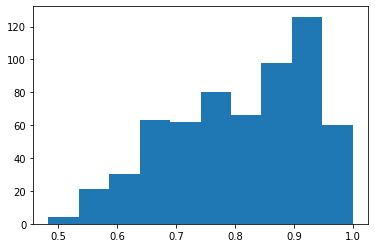

In [15]:
plt.hist(p_corrects)